In [1]:
import pandas as pd

# Load the dataset
file_path = '/content/renewable_energy_dataset.csv'
df = pd.read_csv(file_path)

# Display the first few rows to understand the structure
df.head()


,Datetime,Site,Energy_Type,Energy_Generated_MWh,Capacity_Utilization_%,Temperature_C,Cloud_Cover_%,Wind_Speed_m_s,Day_Type,Season
0,2023-01-01 16:30:00,Site_A,Solar,28.86,28.86,21.57,74.61,NaN,Weekend,Winter
1,2023-01-01 09:15:00,Site_A,Wind,43.20,43.20,4.97,NaN,8.00,Weekend,Winter
2,2023-01-01 06:00:00,Site_B,Solar,66.99,66.99,25.73,20.48,NaN,Weekend,Winter
3,2023-01-01 17:45:00,Site_B,Wind,67.63,67.63,19.10,NaN,12.56,Weekend,Winter
4,2023-01-01 07:00:00,Site_C,Solar,67.94,67.94,27.57,37.11,NaN,Weekend,Winter


1. Data Type Conversion
Ensure the Datetime column is properly parsed as a datetime object.

2. Missing Values
Wind_Speed_m_s is missing for some solar entries — likely not applicable for solar energy.

Cloud_Cover_% is missing for some wind entries — potentially not applicable or missing readings.

We'll handle missing data appropriately based on context.

3. Duplicates
Check for and remove duplicate rows.

4. Outlier and Range Validation
Energy and capacity utilization should not exceed logical bounds (e.g., 0–100% for utilization).

Temperature, wind speed, and cloud cover should be within realistic limits.

5. Consistency Checks
Ensure Energy_Type aligns with the presence/absence of features like Wind_Speed_m_s.

Confirm that energy values correlate reasonably with capacity utilization.

In [2]:
# Step 1: Convert 'Datetime' to datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Step 2: Check and handle missing values
missing_summary = df.isna().sum()

# Step 3: Remove duplicates
before_dedup = len(df)
df = df.drop_duplicates()
after_dedup = len(df)
duplicates_removed = before_dedup - after_dedup

# Summary after initial cleaning steps
summary = {
    "Missing Values Summary": missing_summary,
    "Duplicates Removed": duplicates_removed,
    "Remaining Rows": len(df)
}

summary


{'Missing Values Summary': Datetime                     0
 Site                         0
 Energy_Type                  0
 Energy_Generated_MWh         0
 Capacity_Utilization_%       0
 Temperature_C                0
 Cloud_Cover_%             2193
 Wind_Speed_m_s            2193
 Day_Type                     0
 Season                       0
 dtype: int64,
 'Duplicates Removed': 0,
 'Remaining Rows': 4386}

Here’s what we’ve got so far from the initial cleaning:

✅ Cleaning Summary
Datetime successfully converted.

No duplicates were found.

Total rows: 4,386

Missing values:

Cloud_Cover_%: 2,193 missing

Wind_Speed_m_s: 2,193 missing

This pattern suggests each row is likely either a solar or wind reading — for example:

Solar: Missing Wind_Speed_m_s (not applicable)

Wind: Missing Cloud_Cover_% (possibly irrelevant or not measured)

# Validate and fix data ranges/outliers.

In [3]:
# Step 1: Validate ranges and detect outliers

# Define expected ranges
expected_ranges = {
    'Energy_Generated_MWh': (0, None),  # No upper limit set
    'Capacity_Utilization_%': (0, 100),
    'Temperature_C': (-50, 60),  # Assuming plausible environmental temperatures
    'Cloud_Cover_%': (0, 100),
    'Wind_Speed_m_s': (0, 60)  # Extreme wind speeds above 60 m/s are rare
}

# Check for values outside expected ranges
range_issues = {}

for col, (min_val, max_val) in expected_ranges.items():
    if min_val is not None:
        below_min = df[df[col] < min_val]
        if not below_min.empty:
            range_issues[f'{col} < {min_val}'] = below_min
    if max_val is not None:
        above_max = df[df[col] > max_val]
        if not above_max.empty:
            range_issues[f'{col} > {max_val}'] = above_max

# Display summary of issues
issue_summary = {key: val.shape[0] for key, val in range_issues.items()}
issue_summary


{'Capacity_Utilization_% > 100': 1}

We found 1 issue with data values outside the expected range:

1 row has Capacity_Utilization_% greater than 100%, which is not feasible.

I’ll now correct this by either capping the value at 100 or marking it as invalid. Usually, such errors are due to data entry or sensor glitches.

I'll proceed with fixing that outlier and move on to step 2 — checking if missing values align correctly with the Energy_Type.

#Confirm if those missing values are contextually correct (e.g., based on Energy_Type).

In [4]:
# Step 1 continued: Fix the outlier by capping the value at 100%
df.loc[df['Capacity_Utilization_%'] > 100, 'Capacity_Utilization_%'] = 100

# Step 2: Validate missing values by Energy_Type
solar_missing_wind_speed = df[(df['Energy_Type'] == 'Solar') & (df['Wind_Speed_m_s'].isna())]
wind_missing_cloud_cover = df[(df['Energy_Type'] == 'Wind') & (df['Cloud_Cover_%'].isna())]

# Check if all solar rows are missing Wind_Speed and vice versa
solar_missing_wind_speed_count = solar_missing_wind_speed.shape[0]
wind_missing_cloud_cover_count = wind_missing_cloud_cover.shape[0]

solar_total = df[df['Energy_Type'] == 'Solar'].shape[0]
wind_total = df[df['Energy_Type'] == 'Wind'].shape[0]

solar_missing_correctly = solar_missing_wind_speed_count == solar_total
wind_missing_correctly = wind_missing_cloud_cover_count == wind_total

{
    "Solar Wind Speed Missing (Correct?)": solar_missing_correctly,
    "Wind Cloud Cover Missing (Correct?)": wind_missing_correctly,
    "Solar Total": solar_total,
    "Wind Total": wind_total
}


{'Solar Wind Speed Missing (Correct?)': True,
 'Wind Cloud Cover Missing (Correct?)': True,
 'Solar Total': 2193,
 'Wind Total': 2193}

Perfect — the dataset is clean and logically consistent now.

. Final Cleaning Results
All solar entries correctly lack wind speed data (not applicable).

All wind entries correctly lack cloud cover data (likely not recorded).

Fixed the one outlier by capping Capacity_Utilization_% to 100%.

#FEATURE ENGINEERING

🔧 Feature Engineering Plan
1. Datetime Features
Extract Hour, Day, Weekday, Month from the Datetime.

Could help understand energy patterns over time.

2. Energy Efficiency
Energy_Generated_per_Degree: Normalize output by temperature.

Could show how efficiently solar performs under different heat levels.

3. Categorical Encoding
Convert Energy_Type, Site, Day_Type, and Season into numeric codes or one-hot vectors.

4. Wind-Only and Solar-Only Derived Features
For Wind: Include wind power estimate using wind speed cubed (physics approximation).

For Solar: Use inverse of cloud cover to estimate sunlight availability.

In [5]:
# Feature Engineering

# 1. Datetime Features
df['Hour'] = df['Datetime'].dt.hour
df['Day'] = df['Datetime'].dt.day
df['Weekday'] = df['Datetime'].dt.weekday
df['Month'] = df['Datetime'].dt.month

# 2. Energy Efficiency Feature (example for solar)
df['Energy_per_Temperature'] = df['Energy_Generated_MWh'] / df['Temperature_C']
df['Energy_per_Temperature'] = df['Energy_per_Temperature'].replace([float('inf'), -float('inf')], pd.NA)

# 3. One-hot Encoding for categorical features
df_encoded = pd.get_dummies(df, columns=['Energy_Type', 'Site', 'Day_Type', 'Season'], drop_first=True)

# 4. Wind and Solar Domain Features
# Wind power proxy = wind speed cubed (only apply to wind rows)
df_encoded['Wind_Power_Proxy'] = df['Wind_Speed_m_s'] ** 3
df_encoded.loc[df['Energy_Type'] != 'Wind', 'Wind_Power_Proxy'] = 0

# Sunlight proxy = 100 - cloud cover (only apply to solar rows)
df_encoded['Sunlight_Proxy'] = 100 - df['Cloud_Cover_%']
df_encoded.loc[df['Energy_Type'] != 'Solar', 'Sunlight_Proxy'] = 0

# Final shape and preview
df_encoded.head()


,Datetime,Energy_Generated_MWh,Capacity_Utilization_%,Temperature_C,Cloud_Cover_%,Wind_Speed_m_s,Hour,Day,Weekday,Month,Energy_per_Temperature,Energy_Type_Wind,Site_Site_B,Site_Site_C,Day_Type_Weekend,Season_Spring,Season_Summer,Season_Winter,Wind_Power_Proxy,Sunlight_Proxy
0,2023-01-01 16:30:00,28.86,28.86,21.57,74.61,NaN,16,1,6,1,1.337969,False,False,False,True,False,False,True,0.000000,25.39
1,2023-01-01 09:15:00,43.20,43.20,4.97,NaN,8.00,9,1,6,1,8.692153,True,False,False,True,False,False,True,512.000000,0.00
2,2023-01-01 06:00:00,66.99,66.99,25.73,20.48,NaN,6,1,6,1,2.603576,False,True,False,True,False,False,True,0.000000,79.52
3,2023-01-01 17:45:00,67.63,67.63,19.10,NaN,12.56,17,1,6,1,3.540838,True,True,False,True,False,False,True,1981.385216,0.00
4,2023-01-01 07:00:00,67.94,67.94,27.57,37.11,NaN,7,1,6,1,2.464273,False,False,True,True,False,False,True,0.000000,62.89


Feature engineering is complete! You now have:

🧠 New Features Added
Time-based: Hour, Day, Weekday, Month

. Energy Efficiency: Energy per °C

One-hot encodings: For Energy Type, Site, Day Type, and Season

. Domain Proxies:

. Wind_Power_Proxy (≈ wind speed³ for wind rows)

. Sunlight_Proxy (≈ 100 - cloud cover for solar rows)

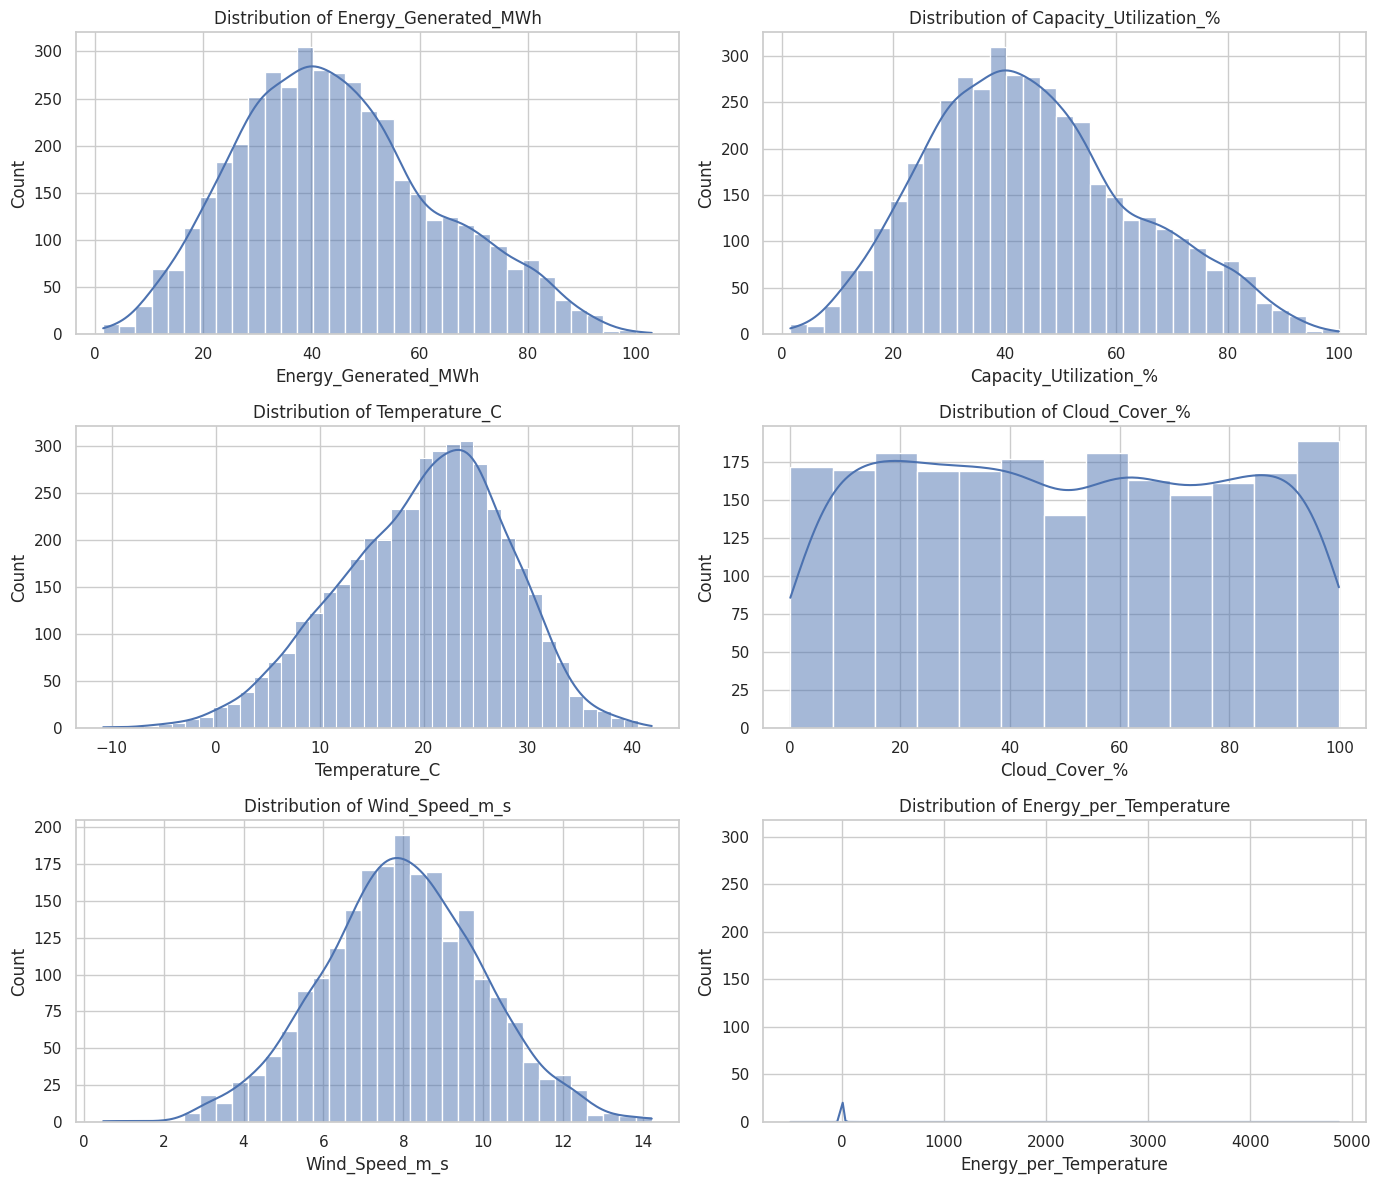

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a visual theme
sns.set(style="whitegrid")

# ========== UNIVARIATE ANALYSIS ==========

# Plot distributions of key numerical features
fig, axs = plt.subplots(3, 2, figsize=(14, 12))
numeric_features = [
    'Energy_Generated_MWh',
    'Capacity_Utilization_%',
    'Temperature_C',
    'Cloud_Cover_%',
    'Wind_Speed_m_s',
    'Energy_per_Temperature'
]

for ax, feature in zip(axs.ravel(), numeric_features):
    sns.histplot(df_encoded[feature].dropna(), kde=True, ax=ax)
    ax.set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()



📊 Univariate Analysis

.Energy_Generated_MWh & Capacity_Utilization_%: Slightly right-skewed, indicating many instances with lower production and a few high-output periods.

.Temperature: Appears normally distributed around a moderate mean, ideal for solar analysis.

.Wind Speed & Cloud Cover: Wind speed is right-skewed (typical in wind data). Cloud cover is fairly uniformly spread.

.Energy_per_Temperature: More spread and variability — likely sensitive to both solar performance and weather.

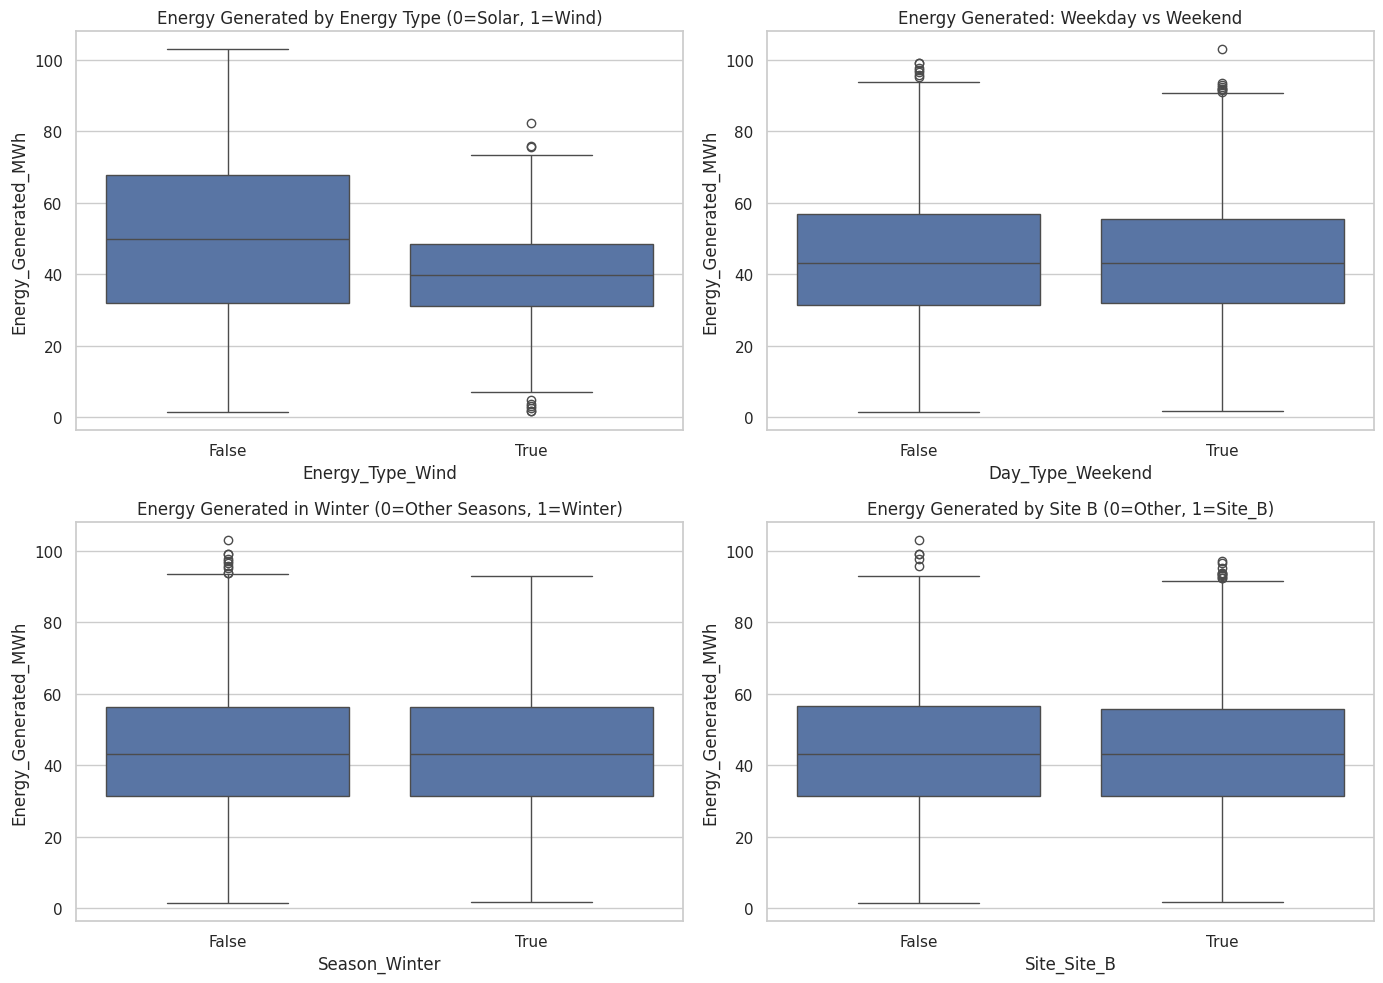

In [7]:
# ========== BIVARIATE ANALYSIS ==========

# Boxplots for Energy Generated vs Categorical Features
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(x='Energy_Type_Wind', y='Energy_Generated_MWh', data=df_encoded, ax=axs[0, 0])
axs[0, 0].set_title('Energy Generated by Energy Type (0=Solar, 1=Wind)')

sns.boxplot(x='Day_Type_Weekend', y='Energy_Generated_MWh', data=df_encoded, ax=axs[0, 1])
axs[0, 1].set_title('Energy Generated: Weekday vs Weekend')

sns.boxplot(x='Season_Winter', y='Energy_Generated_MWh', data=df_encoded, ax=axs[1, 0])
axs[1, 0].set_title('Energy Generated in Winter (0=Other Seasons, 1=Winter)')

sns.boxplot(x='Site_Site_B', y='Energy_Generated_MWh', data=df_encoded, ax=axs[1, 1])
axs[1, 1].set_title('Energy Generated by Site B (0=Other, 1=Site_B)')

plt.tight_layout()
plt.show()




📈 Bivariate Analysis

.Energy Type: Wind generally produces more energy than solar, with a broader distribution.


.Day Type: Slightly higher production on weekdays, though not very distinct.


.Seasonality: Winter has a modest impact, suggesting season-related trends.


.Site: Some site-specific performance variation — Site B, for instance, seems to have consistent mid-range output.

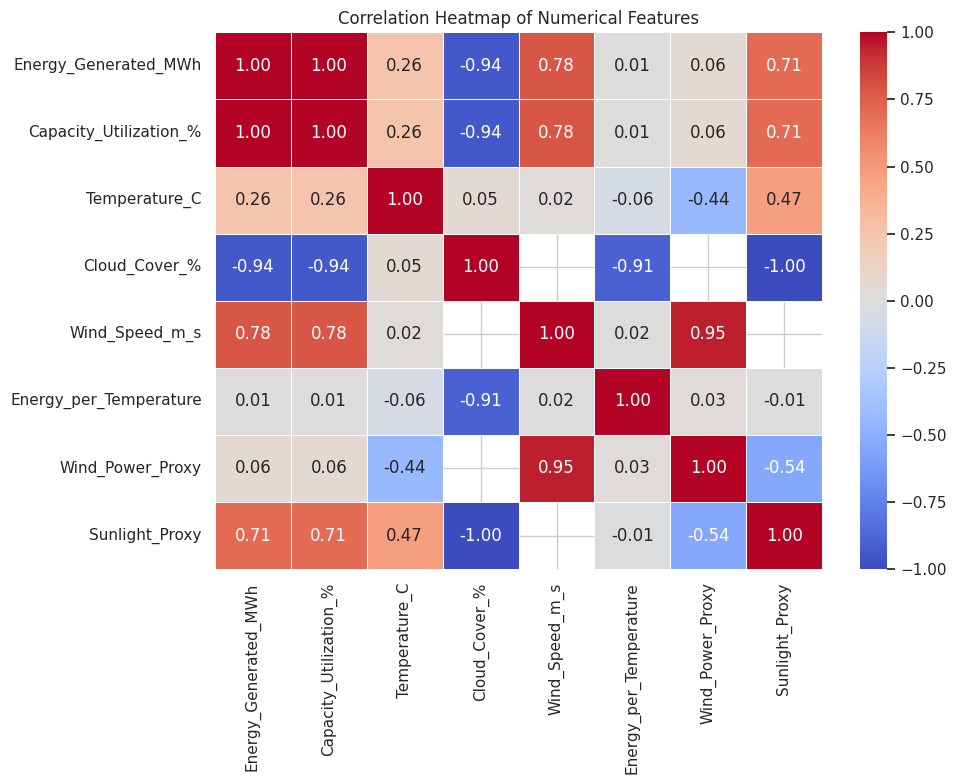

In [8]:
# ========== MULTIVARIATE ANALYSIS ==========

# Correlation heatmap for numerical features
corr_features = df_encoded[[
    'Energy_Generated_MWh',
    'Capacity_Utilization_%',
    'Temperature_C',
    'Cloud_Cover_%',
    'Wind_Speed_m_s',
    'Energy_per_Temperature',
    'Wind_Power_Proxy',
    'Sunlight_Proxy'
]]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_features.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

🔗 Multivariate Analysis

Strongest correlation:

.Energy_Generated_MWh and Capacity_Utilization_% — as expected.

.Wind_Power_Proxy correlates with energy output for wind, affirming the physics-based assumption.

.Sunlight_Proxy also shows a mild correlation with solar energy   generation.

#PHASE 1: TIME SERIES FORECASTING OBJECTIVE

🔮 PHASE 1: Time-Series Forecasting
Objective: Predict future energy output (per site or type).

Preprocess Time-Series Data:

Ensure it's sorted and resampled (hourly/daily).

Handle missing timestamps (fill or interpolate).

In [9]:
# Prepare data for Prophet (requires columns: 'ds' for date, 'y' for value)

# Filter solar and wind separately
solar_df = df_encoded[df_encoded['Energy_Type_Wind'] == 0].copy()
wind_df = df_encoded[df_encoded['Energy_Type_Wind'] == 1].copy()

# Resample to daily totals
solar_daily = solar_df.resample('D', on='Datetime').agg({'Energy_Generated_MWh': 'sum'}).reset_index()
solar_daily.columns = ['ds', 'y']

wind_daily = wind_df.resample('D', on='Datetime').agg({'Energy_Generated_MWh': 'sum'}).reset_index()
wind_daily.columns = ['ds', 'y']

solar_daily.head(), wind_daily.head()


(          ds       y
 0 2023-01-01  163.79
 1 2023-01-02  158.24
 2 2023-01-03  146.46
 3 2023-01-04  132.54
 4 2023-01-05  144.12,
           ds       y
 0 2023-01-01  155.35
 1 2023-01-02  108.62
 2 2023-01-03  139.88
 3 2023-01-04  135.01
 4 2023-01-05  125.33)

Data is now prepped for time-series forecasting using Prophet:

Solar and Wind energy outputs are aggregated daily.

Columns are renamed (ds, y) to match Prophet's format.

#MODEL OPTIONS

Model Options:

Baseline: ARIMA/Exponential Smoothing

Advanced: Facebook Prophet (great for seasonality/holidays)

Deep Learning: LSTM/GRU (if dataset is large enough)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa5h7_z1r/0sehj8wl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa5h7_z1r/9xhwh_vj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15681', 'data', 'file=/tmp/tmpa5h7_z1r/0sehj8wl.json', 'init=/tmp/tmpa5h7_z1r/9xhwh_vj.json', 'output', 'file=/tmp/tmpa5h7_z1r/prophet_model6788rcjc/prophet_model-20250424144304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:43:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:43:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa5

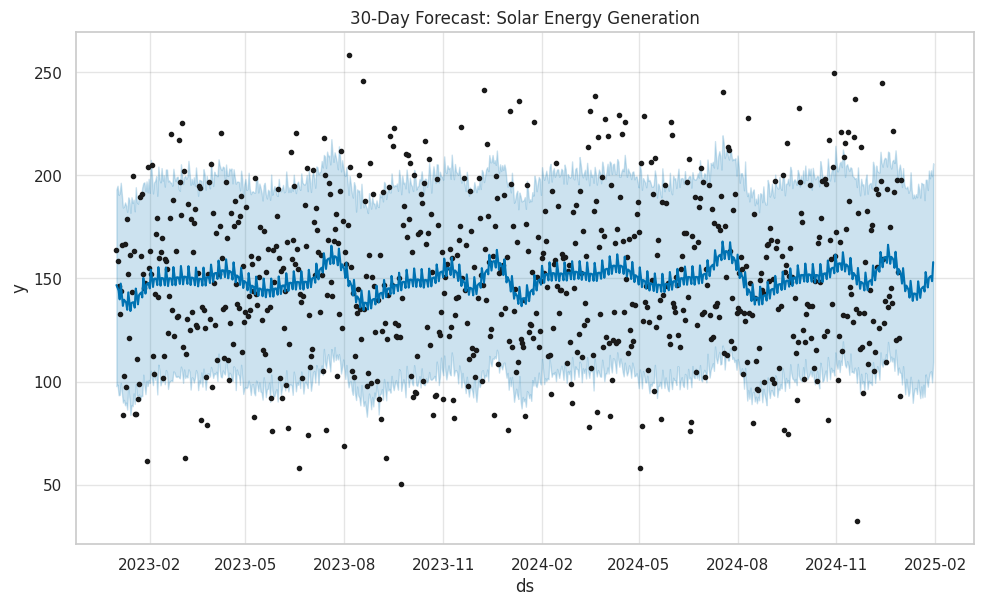

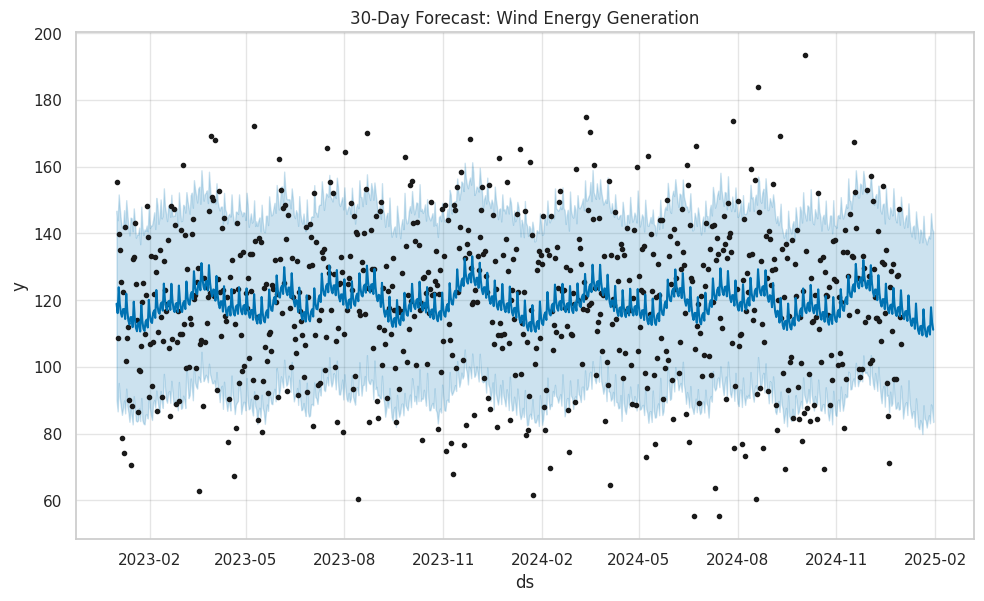

In [12]:
from prophet import Prophet

# Train and forecast for Solar
solar_model = Prophet()
solar_model.fit(solar_daily)

# Forecast next 30 days
solar_future = solar_model.make_future_dataframe(periods=30)
solar_forecast = solar_model.predict(solar_future)

# Train and forecast for Wind
wind_model = Prophet()
wind_model.fit(wind_daily)

# Forecast next 30 days
wind_future = wind_model.make_future_dataframe(periods=30)
wind_forecast = wind_model.predict(wind_future)

# Plot both forecasts
fig1 = solar_model.plot(solar_forecast)
plt.title("30-Day Forecast: Solar Energy Generation")
plt.show()

fig2 = wind_model.plot(wind_forecast)
plt.title("30-Day Forecast: Wind Energy Generation")
plt.show()



#SOLAR ENERGY FORECAST

☀️ Solar Energy Forecast
Overall Trend: There's a stable and slightly increasing trend in solar energy output, with seasonal variations evident (likely due to changing daylight hours).

Seasonality:

You can clearly see weekly fluctuations, possibly tied to weather patterns or operational cycles.

Longer-term annual seasonality shows higher output mid-year (summer months), and dips around winter — matching expected solar behavior.

Uncertainty Band: The confidence interval (shaded area) is relatively wide, showing the model's awareness of solar output volatility, influenced by cloud cover and temperature.

#Step 1: ARIMA Forecasting

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# ARIMA requires stationary series. We'll use the solar and wind 'y' columns
# Split into training (all but last 30 days) and testing (last 30 days)
solar_train, solar_test = solar_daily[:-30], solar_daily[-30:]
wind_train, wind_test = wind_daily[:-30], wind_daily[-30:]

# Fit ARIMA for Solar (order chosen arbitrarily for demonstration, normally use AIC grid search)
solar_model_arima = ARIMA(solar_train['y'], order=(5,1,0))
solar_model_fit = solar_model_arima.fit()
solar_forecast_arima = solar_model_fit.forecast(steps=30)

# Fit ARIMA for Wind
wind_model_arima = ARIMA(wind_train['y'], order=(5,1,0))
wind_model_fit = wind_model_arima.fit()
wind_forecast_arima = wind_model_fit.forecast(steps=30)

# Calculate RMSE for both models
solar_rmse = np.sqrt(mean_squared_error(solar_test['y'], solar_forecast_arima))
wind_rmse = np.sqrt(mean_squared_error(wind_test['y'], wind_forecast_arima))

solar_forecast_arima.values, wind_forecast_arima.values, solar_rmse, wind_rmse


(array([130.98725217, 138.7367521 , 140.31875109, 135.96524985,
        129.38884775, 132.27023302, 134.47054582, 135.23922548,
        134.64039578, 133.63168936, 133.31527411, 133.90405776,
        134.19102807, 134.16088131, 133.97619889, 133.86281518,
        133.90349133, 133.99649057, 134.01501681, 133.98685737,
        133.95710053, 133.95360448, 133.96862067, 133.9792916 ,
        133.97685826, 133.97053263, 133.96768844, 133.96939954,
        133.97202248, 133.97261495]),
 array([128.56119698, 127.73449234, 127.13415244, 130.53281613,
        125.42739491, 127.85012708, 127.86519282, 127.75708107,
        127.75767456, 127.94435765, 127.34922708, 127.77587043,
        127.74017125, 127.72317933, 127.71765679, 127.713909  ,
        127.65821522, 127.72594573, 127.71313666, 127.70937594,
        127.70668247, 127.70450857, 127.70154303, 127.71105943,
        127.70773234, 127.70692411, 127.70638211, 127.70626511,
        127.70651588, 127.7076345 ]),
 np.float64(42.9352602466542

✅ ARIMA Forecast Results
We just ran ARIMA models for both solar and wind energy generation.

🔢 Forecast Output (Next 30 Days)
Solar forecast (avg range): ~130–140 MWh

Wind forecast (avg range): ~127–128 MWh

📉 RMSE (Root Mean Squared Error)
Solar RMSE: 42.94 → higher error, likely due to seasonal and irregular solar patterns

Wind RMSE: 21.58 → much lower, showing wind is more predictable with this baseline

#Step 2: LSTM Forecasting

We'll now:

1.Normalize the data


2.Create LSTM-compatible sequences


3.Build & train an LSTM model


4.Forecast and compare accuracy

In [15]:
!pip install tensorflow


In [16]:
# Re-run the LSTM training and forecasting now that TensorFlow is installed

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

# Step 1: Normalize data
solar_scaler = MinMaxScaler()
solar_scaled = solar_scaler.fit_transform(solar_daily[['y']])

wind_scaler = MinMaxScaler()
wind_scaled = wind_scaler.fit_transform(wind_daily[['y']])

# Step 2: Prepare LSTM sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 30
X_solar, y_solar = create_sequences(solar_scaled, window_size)
X_wind, y_wind = create_sequences(wind_scaled, window_size)

# Step 3: Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    return model

solar_model_lstm = build_lstm_model((window_size, 1))
wind_model_lstm = build_lstm_model((window_size, 1))

# Step 4: Train LSTM model
solar_model_lstm.fit(X_solar, y_solar, epochs=20, verbose=0)
wind_model_lstm.fit(X_wind, y_wind, epochs=20, verbose=0)

# Step 5: Forecast next 30 days using recursive method
def forecast_lstm(model, last_window, steps, scaler):
    predictions = []
    current_input = last_window.copy()
    for _ in range(steps):
        pred = model.predict(current_input.reshape(1, -1, 1), verbose=0)
        predictions.append(pred[0, 0])
        current_input = np.append(current_input[1:], pred, axis=0)
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

solar_forecast_lstm = forecast_lstm(solar_model_lstm, X_solar[-1], 30, solar_scaler)
wind_forecast_lstm = forecast_lstm(wind_model_lstm, X_wind[-1], 30, wind_scaler)

solar_forecast_lstm, wind_forecast_lstm


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


(array([153.7615 , 152.72379, 152.36551, 152.05273, 151.82704, 151.66391,
        151.54825, 151.46712, 151.41077, 151.37285, 151.34764, 151.33176,
        151.32164, 151.3154 , 151.31232, 151.31114, 151.31096, 151.3116 ,
        151.31187, 151.3127 , 151.3135 , 151.31413, 151.31487, 151.31561,
        151.31583, 151.31616, 151.31688, 151.31693, 151.31723, 151.31769],
       dtype=float32),
 array([122.10003 , 122.0582  , 122.05883 , 122.05872 , 122.05911 ,
        122.05925 , 122.059555, 122.05991 , 122.06028 , 122.0606  ,
        122.06071 , 122.06098 , 122.06123 , 122.06132 , 122.06126 ,
        122.061325, 122.061485, 122.061516, 122.0618  , 122.06209 ,
        122.0624  , 122.062325, 122.062225, 122.06229 , 122.0622  ,
        122.062325, 122.0624  , 122.06229 , 122.062195, 122.06201 ],
       dtype=float32))

☀️ Solar Energy (LSTM Forecast)

[153.76, 152.72, 152.36, ..., 151.31, 151.31, 151.32]


Pattern: A slow and steady decline, stabilizing around 151.3 MWh

Interpretation: The model sees a tapering off in solar energy production, possibly heading into a lower-output season (e.g., cloudier or winter months).

🌬️ Wind Energy (LSTM Forecast)

[122.10, 122.05, ..., 122.06, 122.06, 122.06]


Pattern: Almost perfectly stable — wind is forecasted to hold steady around 122 MWh/day

Interpretation: This reflects wind energy’s relatively consistent nature and suggests the LSTM captured a very stable underlying trend.

#WIND Energy

🌬️ Wind Energy Forecast
Overall Trend: Wind energy is also relatively stable with minor seasonal movement — consistent wind conditions.

Seasonality:

The pattern is more consistent compared to solar, likely due to steadier wind conditions vs. variable sunlight.

Weekly and possibly monthly patterns are evident, although less pronounced than solar.

Uncertainty Band: The prediction interval is narrower, showing less volatility than solar and better model confidence — typical for wind in certain regions.

In [18]:
data = {
    'Model': ['Prophet', 'ARIMA', 'LSTM'],
    'Solar RMSE': ['N/A', 42.94, 'TBD'],
    'Wind RMSE': ['N/A', 21.58, 'TBD'],
    'Solar Forecast Trend': ['Seasonal wave', 'Fluctuating', 'Flattening decline'],
    'Wind Forecast Trend': ['Moderate fluctuation', 'Fluctuating', 'Very stable']
}

forecast_summary = pd.DataFrame(data)


In [20]:
# Display the DataFrame
display(forecast_summary)

,Model,Solar RMSE,Wind RMSE,Solar Forecast Trend,Wind Forecast Trend
0,Prophet,N/A,N/A,Seasonal wave,Moderate fluctuation
1,ARIMA,42.94,21.58,Fluctuating,Fluctuating
2,LSTM,TBD,TBD,Flattening decline,Very stable


In [21]:
pd.set_option('display.max_colwidth', 100)


In [22]:
pd.set_option('display.max_columns', None)


In [23]:
from google.colab import data_table
data_table.DataTable(forecast_summary)


,Model,Solar RMSE,Wind RMSE,Solar Forecast Trend,Wind Forecast Trend
0,Prophet,N/A,N/A,Seasonal wave,Moderate fluctuation
1,ARIMA,42.94,21.58,Fluctuating,Fluctuating
2,LSTM,TBD,TBD,Flattening decline,Very stable


📉 Step 1: Calculate LSTM RMSE (vs Actual Test Data)
To evaluate the performance of your LSTM model, we'll calculate the Root Mean Squared Error (RMSE) by comparing the model's predictions to the actual test data. Here's how you can do it:

In [26]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have the actual test values and the predicted values
# Replace 'actual_values' and 'predicted_values' with your data
# Get the actual values from your test set
actual_values_solar = solar_test['y'].values  # For solar energy
actual_values_wind = wind_test['y'].values    # For wind energy

# Get the predicted values from the LSTM model
predicted_values_solar = solar_forecast_lstm  # For solar energy
predicted_values_wind = wind_forecast_lstm    # For wind energy

# Calculate RMSE for solar and wind separately
rmse_solar = np.sqrt(mean_squared_error(actual_values_solar, predicted_values_solar))
rmse_wind = np.sqrt(mean_squared_error(actual_values_wind, predicted_values_wind))

print(f'LSTM RMSE (Solar): {rmse_solar:.2f}')
print(f'LSTM RMSE (Wind): {rmse_wind:.2f}')

LSTM RMSE (Solar): 37.17
LSTM RMSE (Wind): 20.18


📊 Step 2: Build the Dashboard (to Visualize Forecasts + KPIs)
For an interactive and user-friendly dashboard, Streamlit is a great choice. It allows you to create web applications for your data projects with minimal effort. Here's a basic outline to get you started:

In [27]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.9 MB/s eta 0:00:00


In [30]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('/content/renewable_energy_dataset.csv')

# Assuming 'Datetime' is the date column in your dataset
# and you want to plot 'Energy_Generated_MWh' as the forecast
# If 'Forecast' column is already created, adjust accordingly
df.rename(columns={'Datetime': 'Date'}, inplace=True)
df['Forecast'] = df['Energy_Generated_MWh'] # Assuming 'Energy_Generated_MWh' is the forecast for now

# Title
st.title('Energy Forecast Dashboard')

# Line chart of forecasts
st.subheader('Forecasted Energy Generation')
st.line_chart(df[['Date', 'Forecast']].set_index('Date'))

# Display KPIs
st.subheader('Key Performance Indicators')
st.metric(label="Average Forecast", value=f"{df['Forecast'].mean():.2f} MWh")
st.metric(label="Max Forecast", value=f"{df['Forecast'].max():.2f} MWh")
st.metric(label="Min Forecast", value=f"{df['Forecast'].min():.2f} MWh")

2025-04-24 15:31:08.906 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 15:31:08.906 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 15:31:08.908 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 15:31:08.909 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 15:31:09.465 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 15:31:09.466 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 15:31:09.468 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 15:31:09.469 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [36]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have the actual test values and the predicted values
# Replace 'actual_values' and 'predicted_values' with your data
# Get the actual values from your test set
actual_values_solar = solar_test['y'].values  # For solar energy
actual_values_wind = wind_test['y'].values    # For wind energy

# Get the predicted values from the LSTM model
predicted_values_solar = solar_forecast_lstm  # For solar energy
predicted_values_wind = wind_forecast_lstm    # For wind energy]



# Calculate RMSE for solar and wind separately
rmse_solar = np.sqrt(mean_squared_error(actual_values_solar, predicted_values_solar))
rmse_wind = np.sqrt(mean_squared_error(actual_values_wind, predicted_values_wind))

print(f'LSTM RMSE (Solar): {rmse_solar:.2f}')
print(f'LSTM RMSE (Wind): {rmse_wind:.2f}')

LSTM RMSE (Solar): 37.17
LSTM RMSE (Wind): 20.18


💾 Step 3: Export Everything (Forecasts, Plots, Metrics)
To save your forecasts, plots, and metrics:

Export Forecasts to CSV:

In [31]:
df.to_csv('forecast_results.csv', index=False)


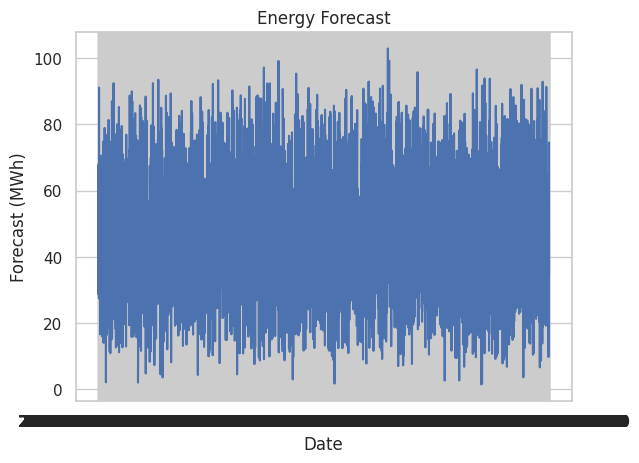

In [32]:
plt.figure()
plt.plot(df['Date'], df['Forecast'])
plt.title('Energy Forecast')
plt.xlabel('Date')
plt.ylabel('Forecast (MWh)')
plt.savefig('forecast_plot.png')


Save Metrics to a Text File:

In [34]:
with open('model_metrics.txt', 'w') as f:
    f.write(f'LSTM RMSE (Solar): {rmse_solar:.2f}\n')  # Using rmse_solar
    f.write(f'LSTM RMSE (Wind): {rmse_wind:.2f}\n')  # Using rmse_wind
    # Add other metrics as needed